KeyboardInterrupt: ignored

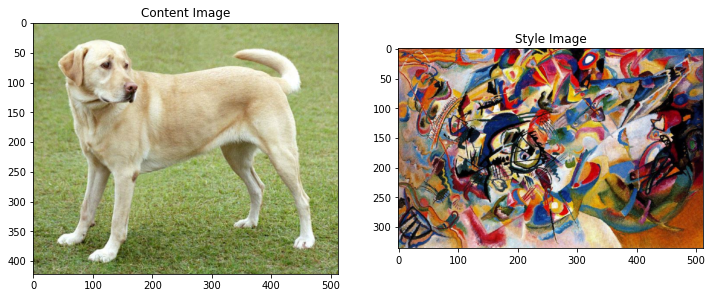

In [ ]:
# https://thispersondoesnotexist.com/
# GAN
# https://www.samsungsds.com/global/ko/support/insights/Generative-adversarial-network-AI-2.html
# https://ssully.joins.com/View/1092
# -*- coding: utf-8 -*-
# Neural Style Trasnfer 예제 - Keras API를 이용한 구현
# Reference : https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
import time

# tensor를 이미지로 변환합니다.
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]

  return PIL.Image.fromarray(tensor)

# path_to_img 경로에서 이미지를 불러옵니다.
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]

  return img

# 이미지를 화면에 plot 합니다.
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

# 값을 0에서 1사이로 clip합니다.
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# gram matrix를 정의합니다.
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)

  return result/(num_locations)

# 학습을 위한 설정값들을 지정합니다.
style_weight=1e-2
content_weight=1e4
total_variation_weight=30
epochs = 10
steps_per_epoch = 100

# content 이미지와 style 이미지를 다운받을 경로를 설정합니다.
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg') # https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
import os
# content 이미지와 style 이미지를 불러온뒤 화면에 띄워서 확인합니다.
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')
plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')
plt.waitforbuttonpress()
plt.close()

# imagnet 데이터셋에 대해 pre-train된 VGGNet을 불러온뒤 각각의 레이어 이름을 출력해봅니다.
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
for layer in vgg.layers:
  print(layer.name)

# content 이미지에서 feature map을 추출할 레이어를 지정합니다.
content_layers = ['block5_conv2']

# style 이미지에서 feature map을 추출할 레이어들을 지정합니다.
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def vgg_layers(layer_names):
  """ VGGNet 중간 레이어에서 추출한 feature map들을 반환합니다."""
  # imagnet 데이터셋에 대해 pre-train된 VGGNet을 불러옵니다.
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)

  return model

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

# 각 style 레이어의 feature map 정보를 출력해봅니다.
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()


# tf.keras.Model을 이용해서 Neural Style Transfer 모델을 정의합니다.
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "[0,1] 사이의 값을 가진 float 타입의 input을 받습니다."
    inputs = inputs * 255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

# Neural Style Transfer 모델을 선언합니다.
extractor = StyleContentModel(style_layers, content_layers)
# content 이미지와 style 이미지로부터 feature map들을 추출합니다.
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# 최적화를 위한 Adam 옵티마이저를 선언합니다.
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# Neural Style Tasnfer를 위한 loss를 정의합니다.
def style_content_loss(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs['content']
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)
                         for name in style_outputs.keys()])
  style_loss *= style_weight / num_style_layers

  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)
                           for name in content_outputs.keys()])
  content_loss *= content_weight / num_content_layers
  loss = style_loss + content_loss

  return loss

# total variation loss를 정의합니다.
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)

  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

# 최적화를 위한 function을 정의합니다.
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    #loss += total_variation_weight*tf.image.total_variation(image) # tf.image.total_variation API를 이용한 구현
    loss += total_variation_weight*total_variation_loss(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

# 합성 이미지로 최적화될 이미지를 tf.Variable로 선언합니다. 빠른 학습을 위해서 content 이미지로 초기화합니다.
synthetic_image = tf.Variable(content_image)

# epochs 횟수만큼 최적화를 진행합니다.
start = time.time()
step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(synthetic_image)
    print(".", end='')
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

# 최적화 결과로 생성된 합성 이미지를 화면에 띄우고 파일로 저장합니다.
plt.imshow(tensor_to_image(synthetic_image))
plt.savefig("stylized-image.png")
plt.waitforbuttonpress()